In [10]:
from kan import KAN, create_dataset
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
import torch
import numpy as np

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
dtype = torch.get_default_dtype()


In [11]:
class Args:
    def __init__(self, **kwargs):
        for key, value in kwargs.items():
            setattr(self, key, value)

args_dict = {
    #'grid': 5,
    'grid': 10,
    'k': 3,
    'seed': 2024,
    'base_fun': "zero",
    #'base_fun': 'identity',
    'sp_trainable': False,
    'sb_trainable': False,
    'affine_trainable': False,
    'update_grid': False,
    #'base_fun': ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','tan','abs'],
    #'spline_noise_scale': 0.1,
    'mode': 'default',
    'init_mode': 'default',
    #'init_mode': 'xavier_in_out',
    'moon_noise': 0.5,
    'steps': 20
}
args = Args(**args_dict)

In [12]:
model = KAN(
    width=[1,1,1],
    device=device,
    grid=args.grid, k=args.k, seed=args.seed,
    #sp_trainable=args.sp_trainable, sb_trainable=args.sb_trainable, affine_trainable=args.affine_trainable,
    #base_fun=args.base_fun,
    mode=args.mode,
    init_mode=args.init_mode
    )

# create dataset
#f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]])**2)
f = lambda x: torch.cos(torch.sin(torch.pi*x[:,[0]]))**2
dataset = create_dataset(f, n_var=1, device=device)

checkpoint directory created: ./model
saving model version 0.0


In [13]:
#model.fit(dataset, opt="LBFGS", steps=20)
results = model.fit(dataset, 
                    opt="LBFGS", 
                    #lamb=1e-4, lamb_coef=10.0,
                    steps=args.steps
                    )


| train_loss: 1.13e-03 | test_loss: 1.19e-03 | reg: 4.10e+00 | : 100%|█| 20/20 [00:06<00:00,  3.12it

saving model version 0.1


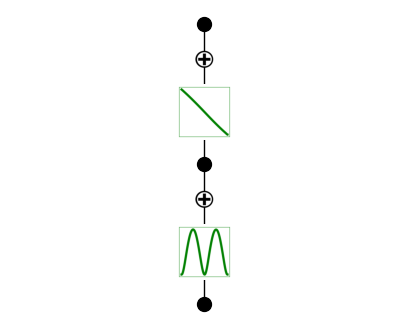

In [14]:
model.plot()

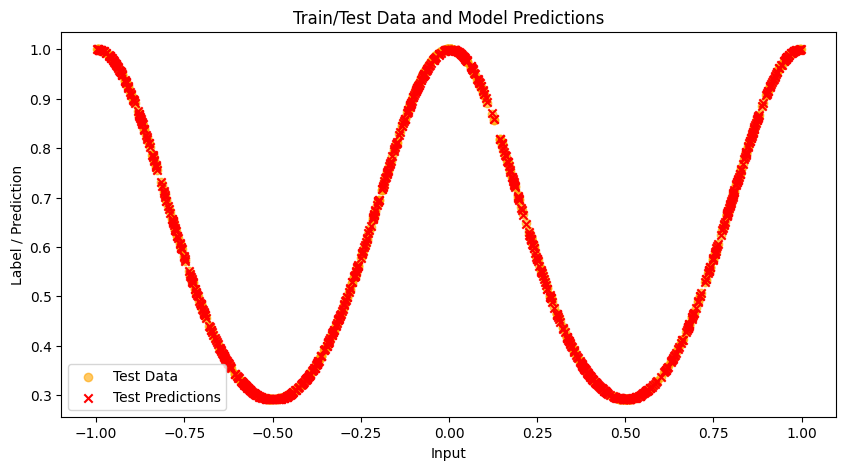

In [15]:
# Plot train data, test data, and model predictions
import matplotlib.pyplot as plt

# Get model predictions for train and test inputs
with torch.no_grad():
    train_preds = model(dataset['train_input']).cpu().numpy()
    test_preds = model(dataset['test_input']).cpu().numpy()

# If regression, use predictions directly; if classification, use argmax
if train_preds.shape[-1] == 1:
    train_pred_vals = train_preds.squeeze()
    test_pred_vals = test_preds.squeeze()
else:
    train_pred_vals = np.argmax(train_preds, axis=1)
    test_pred_vals = np.argmax(test_preds, axis=1)

# Plot
plt.figure(figsize=(10, 5))

# # Train data
# plt.scatter(
#     dataset['train_input'].cpu().numpy().squeeze(),
#     dataset['train_label'].cpu().numpy().squeeze(),
#     label='Train Data', color='blue', alpha=0.6
# )
# plt.scatter(
#     dataset['train_input'].cpu().numpy().squeeze(),
#     train_pred_vals,
#     label='Train Predictions', marker='x', color='navy'
# )

# Test data
plt.scatter(
    dataset['test_input'].cpu().numpy().squeeze(),
    dataset['test_label'].cpu().numpy().squeeze(),
    label='Test Data', color='orange', alpha=0.6
)
plt.scatter(
    dataset['test_input'].cpu().numpy().squeeze(),
    test_pred_vals,
    label='Test Predictions', marker='x', color='red'
)

plt.xlabel('Input')
plt.ylabel('Label / Prediction')
plt.legend()
plt.title('Train/Test Data and Model Predictions')
plt.show()

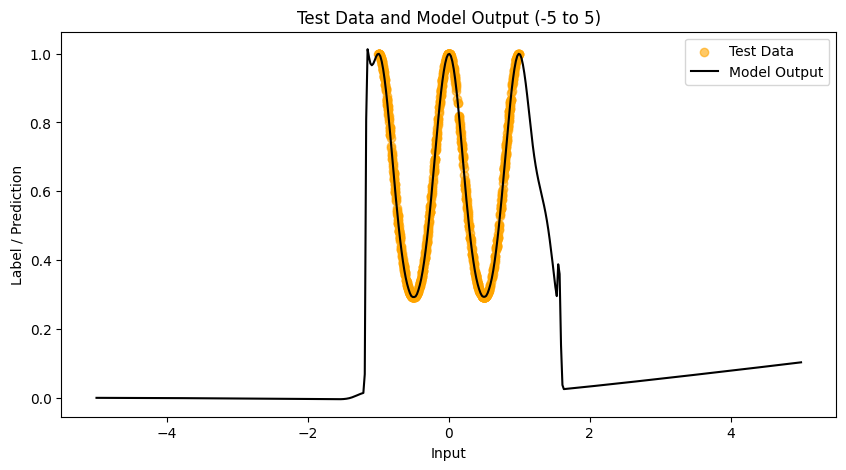

In [16]:
# Generate inputs between -5 and 5
x_range = np.linspace(-5, 5, 500).reshape(-1, 1)
x_tensor = torch.from_numpy(x_range).type(dtype).to(device)

# Get model predictions for the range
with torch.no_grad():
    y_pred = model(x_tensor).cpu().numpy().squeeze()

# Plot test data and model output
plt.figure(figsize=(10, 5))
plt.scatter(dataset['test_input'].cpu().numpy().squeeze(), dataset['test_label'].cpu().numpy().squeeze(), 
            label='Test Data', color='orange', alpha=0.6)
plt.plot(x_range, y_pred, label='Model Output', color='black')
plt.xlabel('Input')
plt.ylabel('Label / Prediction')
plt.legend()
plt.title('Test Data and Model Output (-5 to 5)')
plt.show()

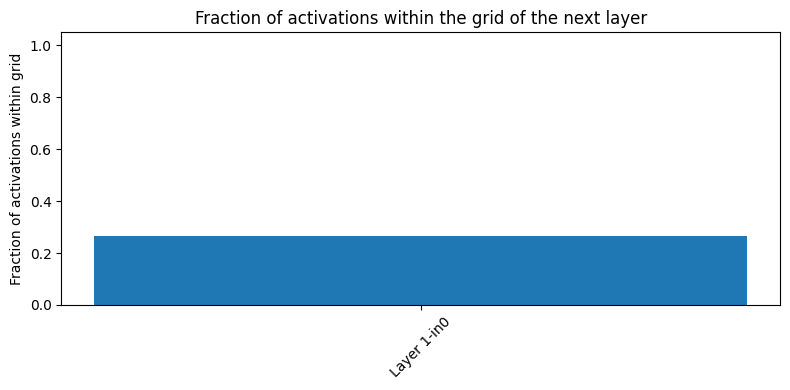

In [17]:
# For each layer, check if the activations (preacts) are within the grid range of the next layer.
# We'll plot, for each layer, the percentage of activations that are within the grid of the next layer.

layer_percentages = []
layer_labels = []

# Forward pass to get activations
with torch.no_grad():
    _ = model(x_tensor)
    # model.acts: list of activations per layer (including input)
    # model.act_fun: list of KANLayer objects

for l in range(len(model.act_fun) - 1):  # skip last layer (no next grid)
    acts = model.acts[l+1]  # activations after layer l (input to layer l+1)
    grid = model.act_fun[l+1].grid  # grid for next layer
    k = model.act_fun[l+1].k

    # For 1D: acts shape (N, width), grid shape (1, num+1+2k)
    # We'll check for each activation if it is within [grid_min, grid_max] for each input neuron
    grid_min = grid[:, k].cpu().numpy()   # leftmost non-extended grid
    grid_max = grid[:, -(k+1)].cpu().numpy()  # rightmost non-extended grid

    acts_np = acts.cpu().numpy()  # shape (N, width)
    in_grid = []
    for i in range(acts_np.shape[1]):
        in_range = (acts_np[:, i] >= grid_min[i]) & (acts_np[:, i] <= grid_max[i])
        in_grid.append(np.mean(in_range))
    layer_percentages.append(in_grid)
    layer_labels.append(f"Layer {l+1}")

# Plot
plt.figure(figsize=(8, 4))
for l, perc in enumerate(layer_percentages):
    plt.bar([f"{layer_labels[l]}-in{i}" for i in range(len(perc))], perc, label=layer_labels[l])
plt.ylabel("Fraction of activations within grid")
plt.ylim(0, 1.05)
plt.title("Fraction of activations within the grid of the next layer")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [18]:
stop here

SyntaxError: invalid syntax (4067800170.py, line 1)

How many connected regions can be created?
this should be correlated to the amount of grid points.
If the coefs are alternating 1, -1, 1, -1, 1  for grid=5 (without border extension)
than we need to count the amount of possible changes in the first derivative to find out the amount the amount of regions it can create?
- How would a 1d experiment of this look like?

thoughts towards possible first dirivative changes:
grid = 5, k=3 
actual amount of grid points; 
5+1 because grid = 5 actually contains 6 grid coefs like stated in the paper: https://arxiv.org/html/2404.19756v1
 3 + (5+1) + 3 = 12
at the borders the values go to 0
Does this mean the the spline creates 12 regions?